In [1]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-on1rjt6t
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-on1rjt6t
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time
import seaborn as sns


import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [3]:
slice0 = pd.read_csv('../data/kagglePump/full_slice0.csv') 
slice1 = pd.read_csv('../data/kagglePump/full_slice1.csv') 
slice2 = pd.read_csv('../data/kagglePump/full_slice2.csv')
slice3 = pd.read_csv('../data/kagglePump/full_slice3.csv') 
slice4 = pd.read_csv('../data/kagglePump/full_slice4.csv')
slice5 = pd.read_csv('../data/kagglePump/full_slice5.csv') 
slice6 = pd.read_csv('../data/kagglePump/full_slice6.csv') 


print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55)


In [4]:
slices_list = [slice0, slice1, slice2, slice3, slice4, slice5, slice6]

In [5]:
# removing the slice4 as its too different from the others.
# as found in plots in notebook 10.

slices_list.pop(4)

print(len(slices_list))

6


In [6]:
COLS_TO_DROP = ['Unnamed: 0','sensor_00', 'sensor_15', 
                'sensor_50', 'sensor_51']
cleanup_nums = {"machine_status": {"NORMAL": 0,
                                   "BROKEN": 1,
                                   "RECOVERING":2}}

for sl in slices_list:
    sl['timestamp']= pd.to_datetime(sl['timestamp']) # cast to datatype
    sl = sl.drop(COLS_TO_DROP,axis=1, inplace=True) # drop cols

for sl in slices_list:
    sl = sl.replace(cleanup_nums)

for sl in slices_list:
    sl = sl.dropna(axis=0, inplace=True) # drop nans
    

In [7]:
print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(2161, 50) (2161, 50) (2109, 50) (2161, 50) (2161, 55) (2161, 50) (2161, 50)


In [8]:
# these plots are absurd in size but lets do it anyways
def plot_slice(one_slice):
    # subplot matrix
    fig, axes = plt.subplots(10, 5, figsize=(20,20))
    fig.tight_layout()

    for col, ax in zip(one_slice.columns[1:-1], axes.flat):
        one_slice[col].plot.line(ax=ax)
        ax.set_title(col)
    # disable leftover axes
    for ax in axes.flat[one_slice.columns[1:-1].size:]:
        ax.set_axis_off()

In [9]:
# plot_slice(slice0)

In [10]:
# plot_slice(slice1)

In [11]:
for i in range(len(slices_list)):
    slices_list[i] = slices_list[i].drop(columns=["timestamp"]).to_numpy()
    slices_list[i] = np.array(slices_list[i][1:])
    print(slices_list[i].shape)


(2160, 49)
(2160, 49)
(2108, 49)
(2160, 49)
(2160, 49)
(2160, 49)


In [12]:
# from list of nps to np of nps
slices_list = np.asarray(slices_list)
slices_list.shape

/opt/app-root/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(6,)

In [13]:
# we have shape 6,2160, 49 with machine status. 
# we want something closer to 300,720,4.
# 300 being num training samples, 720 being datapoints per sample (12 hrs), 4 sensor cols.
window_shape = (720, 49)
windowed_data = view_as_windows(slices_list[0], window_shape, step=36)
windowed_data = np.squeeze(windowed_data)
windowed_data.shape

(41, 720, 49)

In [14]:
for i in range(1,6):
    temp_window = view_as_windows(slices_list[i], window_shape, step=36)
    temp_window = np.squeeze(temp_window)
    windowed_data = np.append(windowed_data, temp_window, axis=0)

In [15]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=windowed_data.shape[1],
    sample_len=20, # trying a larger sample_len
    batch_size=min(1000, windowed_data.shape[0]),
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [16]:
# Recommended to train with a GPU 
torch.cuda.is_available()

True

In [17]:
start = time.time()
model.train_numpy(
    windowed_data, 
    feature_types=[OutputType.CONTINUOUS] * (windowed_data.shape[2]-1) + [OutputType.DISCRETE]

)
stop = time.time()


2022-08-10 13:35:48,474 : MainThread : INFO : epoch: 0
2022-08-10 13:35:49,186 : MainThread : INFO : epoch: 1
2022-08-10 13:35:49,702 : MainThread : INFO : epoch: 2
2022-08-10 13:35:50,227 : MainThread : INFO : epoch: 3
2022-08-10 13:35:50,744 : MainThread : INFO : epoch: 4
2022-08-10 13:35:51,268 : MainThread : INFO : epoch: 5
2022-08-10 13:35:51,799 : MainThread : INFO : epoch: 6
2022-08-10 13:35:52,323 : MainThread : INFO : epoch: 7
2022-08-10 13:35:52,840 : MainThread : INFO : epoch: 8
2022-08-10 13:35:53,362 : MainThread : INFO : epoch: 9
2022-08-10 13:35:53,882 : MainThread : INFO : epoch: 10
2022-08-10 13:35:54,402 : MainThread : INFO : epoch: 11
2022-08-10 13:35:54,920 : MainThread : INFO : epoch: 12
2022-08-10 13:35:55,437 : MainThread : INFO : epoch: 13
2022-08-10 13:35:55,955 : MainThread : INFO : epoch: 14
2022-08-10 13:35:56,483 : MainThread : INFO : epoch: 15
2022-08-10 13:35:57,016 : MainThread : INFO : epoch: 16
2022-08-10 13:35:57,546 : MainThread : INFO : epoch: 17
20

In [18]:
print(f"Training time: {stop - start}s")

Training time: 5252.930029392242s


In [19]:
# saving model for future use 
model.save("../models/dgan_model_5_48_sensors.pt")

In [20]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1)

In [21]:
synthetic_features[0].shape

(720, 49)

In [22]:
sensor_cols = slice0.columns
sensor_cols = sensor_cols[1:]

In [23]:
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols)
synthetic_df.shape

(720, 49)

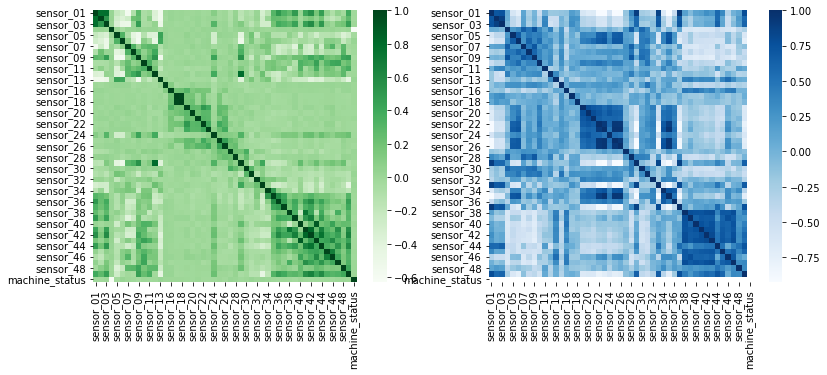

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(slice2.corr(),cmap='Greens',ax=ax1)
sns.heatmap(synthetic_df.corr(),cmap='Blues',ax=ax2)
plt.show()

will do more testing in a dedicated nb for testing model efficacy.